In [1]:
%matplotlib inline


# Compute the power spectral density of raw data

This script shows how to compute the power spectral density (PSD)
of measurements on a raw dataset. It also show the effect of applying SSP
to the data to reduce ECG and EOG artifacts.


In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Eric Larson <larson.eric.d@gmail.com>
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io, read_proj, read_selection
from mne.datasets import sample
from mne.time_frequency import psd_multitaper

print(__doc__)

Automatically created module for IPython interactive environment


## Load data

We'll load a sample MEG dataset, along with SSP projections that will
allow us to reduce EOG and ECG artifacts. For more information about
reducing artifacts, see the preprocessing section in `documentation`.



In [3]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
proj_fname = data_path + '/MEG/sample/sample_audvis_eog-proj.fif'

tmin, tmax = 0, 60  # use the first 60s of data

# Setup for reading the raw data (to save memory, crop before loading)
raw = io.read_raw_fif(raw_fname).crop(tmin, tmax).load_data()
raw.info['bads'] += ['MEG 2443', 'EEG 053']  # bads + 2 more

# Add SSP projection vectors to reduce EOG and ECG artifacts
projs = read_proj(proj_fname)
raw.add_proj(projs, remove_existing=True)


fmin, fmax = 2, 300  # look at frequencies between 2 and 300Hz
n_fft = 2048  # the FFT size (n_fft). Ideally a power of 2

Opening raw data file /Users/jose/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 36037  =      0.000 ...    60.000 secs...
    Read a total of 6 projection items:
        EOG-planar-998--0.200-0.200-PCA-01 (1 x 203)  idle
        EOG-planar-998--0.200-0.200-PCA-02 (1 x 203)  idle
        EOG-axial-998--0.200-0.200-PCA-01 (1 x 102)  idle
        EOG-axial-998--0.200-0.200-PCA-02 (1 x 102)  idle
        EOG-eeg-998--0.200-0.200-PCA-01 (1 x 59)  idle
        EOG-eeg-998--0.200-0.200-PCA-02 (1 x 59)  idle
6 projection items deactivated


## Plot the raw PSD

First we'll visualize the raw PSD of our data. We'll do this on all of the
channels first. Note that there are several parameters to the
:meth:`mne.io.Raw.plot_psd` method, some of which will be explained below.



Effective window size : 3.410 (s)
Effective window size : 3.410 (s)
Effective window size : 3.410 (s)


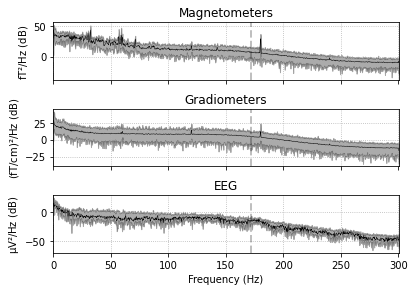

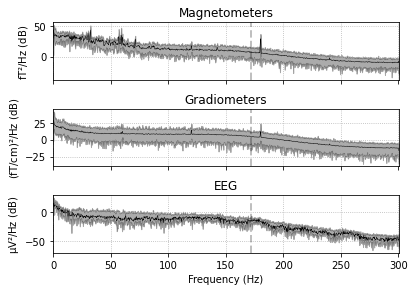

In [4]:
raw.plot_psd(area_mode='range', tmax=10.0, show=False, average=True)

## Plot a cleaned PSD

Next we'll focus the visualization on a subset of channels.
This can be useful for identifying particularly noisy channels or
investigating how the power spectrum changes across channels.

We'll visualize how this PSD changes after applying some standard
filtering techniques. We'll first apply the SSP projections, which is
accomplished with the ``proj=True`` kwarg. We'll then perform a notch filter
to remove particular frequency bands.



Effective window size : 3.410 (s)
Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
Effective window size : 3.410 (s)
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 sec)

Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
Effective window size : 3.410 (s)


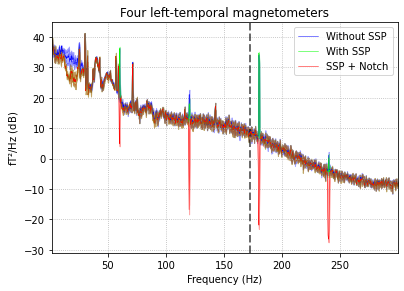

In [5]:
# Pick MEG magnetometers in the Left-temporal region
selection = read_selection('Left-temporal')
picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads', selection=selection)

# Let's just look at the first few channels for demonstration purposes
picks = picks[:4]

plt.figure()
ax = plt.axes()
raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=False, ax=ax, color=(0, 0, 1), picks=picks,
             show=False, average=True)

raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=True, ax=ax, color=(0, 1, 0), picks=picks,
             show=False, average=True)

# And now do the same with SSP + notch filtering
# Pick all channels for notch since the SSP projection mixes channels together
raw.notch_filter(np.arange(60, 241, 60), n_jobs=1, fir_design='firwin')
raw.plot_psd(tmin=tmin, tmax=tmax, fmin=fmin, fmax=fmax, n_fft=n_fft,
             n_jobs=1, proj=True, ax=ax, color=(1, 0, 0), picks=picks,
             show=False, average=True)

ax.set_title('Four left-temporal magnetometers')
leg_lines = [line for line in ax.lines if line.get_linestyle() == '-']
plt.legend(leg_lines, ['Without SSP', 'With SSP', 'SSP + Notch'])

## Alternative functions for PSDs

There are also several functions in MNE that create a PSD using a Raw
object. These are in the :mod:`mne.time_frequency` module and begin with
``psd_*``. For example, we'll use a multitaper method to compute the PSD
below.



Created an SSP operator (subspace dimension = 6)
6 projection items activated
SSP projectors applied...
    Using multitaper spectrum estimation with 7 DPSS windows


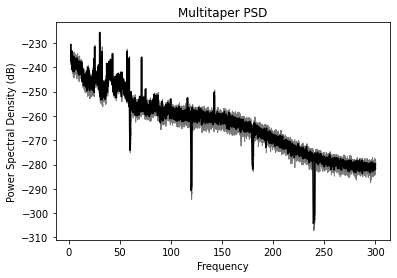

In [6]:
f, ax = plt.subplots()
psds, freqs = psd_multitaper(raw, low_bias=True, tmin=tmin, tmax=tmax,
                             fmin=fmin, fmax=fmax, proj=True, picks=picks,
                             n_jobs=1)
psds = 10 * np.log10(psds)
psds_mean = psds.mean(0)
psds_std = psds.std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD', xlabel='Frequency',
       ylabel='Power Spectral Density (dB)')
plt.show()